In [0]:

import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

In [0]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


In [0]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)

In [0]:
sick_all[:5]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [0]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

In [0]:
import csv
# load these data from local
PATH_TO_FREQUENCIES_FILE = "./frequencies.tsv"
PATH_TO_DOC_FREQUENCIES_FILE = "./doc_frequencies.tsv"


def read_tsv(f):
    frequencies = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t")
        for row in tsv_reader:
            if len(row) == 2:
                frequencies[row[0]] = int(row[1])
            else:
                print(row)

    return frequencies


frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)
doc_frequencies = read_tsv(PATH_TO_DOC_FREQUENCIES_FILE)
doc_frequencies["NUM_DOCS"] = 1288431

['bek']


In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math



In [0]:
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

def run_gse_benchmark(sentences1, sentences2):
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
    sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
        
    sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [gse_sims] = session.run(
            [sim_scores],
            feed_dict={
                sts_input1: [sent1.raw for sent1 in sentences1],
                sts_input2: [sent2.raw for sent2 in sentences2]
            })
    return gse_sims

W0405 13:00:24.413455 140397782247296 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:

def run_experiment(df, benchmarks): 
    
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
        print(label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors
  
import functools as ft

benchmarks = [
              ("GSE", run_gse_benchmark)]

pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment(sick_dev, benchmarks)
pearson_results["SICK-TEST"], spearman_results["SICK-TEST"] = run_experiment(sick_test, benchmarks)
pearson_results["STS-DEV"], spearman_results["STS-DEV"] = run_experiment(sts_dev, benchmarks)
pearson_results["STS-TEST"], spearman_results["STS-TEST"] = run_experiment(sts_test, benchmarks)

GSE 0.7282557389395143
GSE 0.7420298276181728
GSE 0.7513780087313888
GSE 0.7121381309608474


In [0]:
# google sentence encoder experience endding
pearson_results_df.to_csv('pearson.csv')
spearman_results_df.to_csv('sperman.csv')


***Puttting results all together***

In [34]:
import os
os.listdir('./')
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pearson-final.csv to pearson-final.csv
Saving spearman-final.csv to spearman-final.csv
User uploaded file "pearson-final.csv" with length 657 bytes
User uploaded file "spearman-final.csv" with length 654 bytes


In [35]:
import os
os.listdir('./')

['.config',
 'spearman_final.csv',
 'pearson-final.csv',
 'pearson_results.csv',
 'spearman-final.csv',
 'pearson.csv',
 'spearman_results.csv',
 'pearson_final.csv',
 'sperman.csv',
 'sample_data']

In [0]:
import pandas as pd

pearson =pd.read_csv('pearson-final.csv', index_col =0)
spearman =pd.read_csv('spearman-final.csv', index_col =0)
#pearson_results_df = pearson.rename(columns={'DATA','AVG-GLOVE', 'AVG-GLOVE-STOP','AVG-GLOVE-TFIDF', 'AVG-GLOVE-TFIDF-STOP','GSE'})


In [37]:
pearson

,AVG-GLOVE,AVG-GLOVE-STOP,AVG-GLOVE-TFIDF,AVG-GLOVE-TFIDF-STOP,SIF-W2V,SIF-GLOVE,GSE
SICK-DEV,0.659186,0.681603,0.654810,0.655220,0.725238,0.699200,0.728256
SICK-TEST,0.686081,0.702510,0.655609,0.659306,0.729060,0.721051,0.742030
STS-DEV,0.564806,0.696953,0.492541,0.509415,0.767565,0.760014,0.751378
STS-TEST,0.449481,0.617232,0.356688,0.362028,0.689761,0.681436,0.712138


In [38]:
spearman

,AVG-GLOVE,AVG-GLOVE-STOP,AVG-GLOVE-TFIDF,AVG-GLOVE-TFIDF-STOP,SIF-W2V,SIF-GLOVE,GSE
SICK-DEV,0.571957,0.557057,0.526886,0.515857,0.623704,0.580430,0.691470
SICK-TEST,0.574987,0.560772,0.520803,0.513724,0.612711,0.588293,0.687873
STS-DEV,0.629093,0.724758,0.543020,0.551199,0.760609,0.764263,0.757734
STS-TEST,0.476651,0.619786,0.388416,0.396707,0.642436,0.645647,0.695622


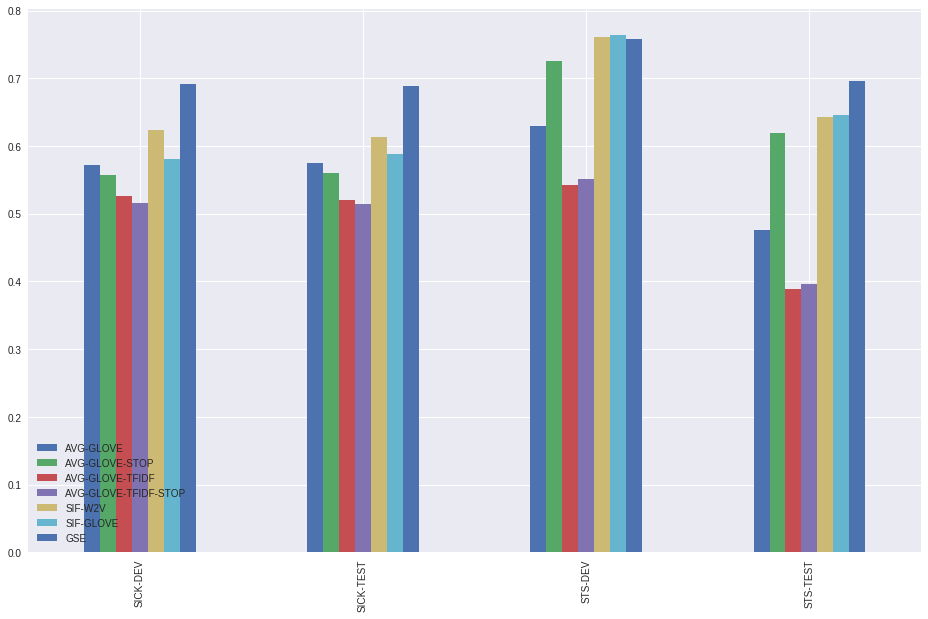

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)
spearman.plot(kind="bar").legend(loc="lower left")

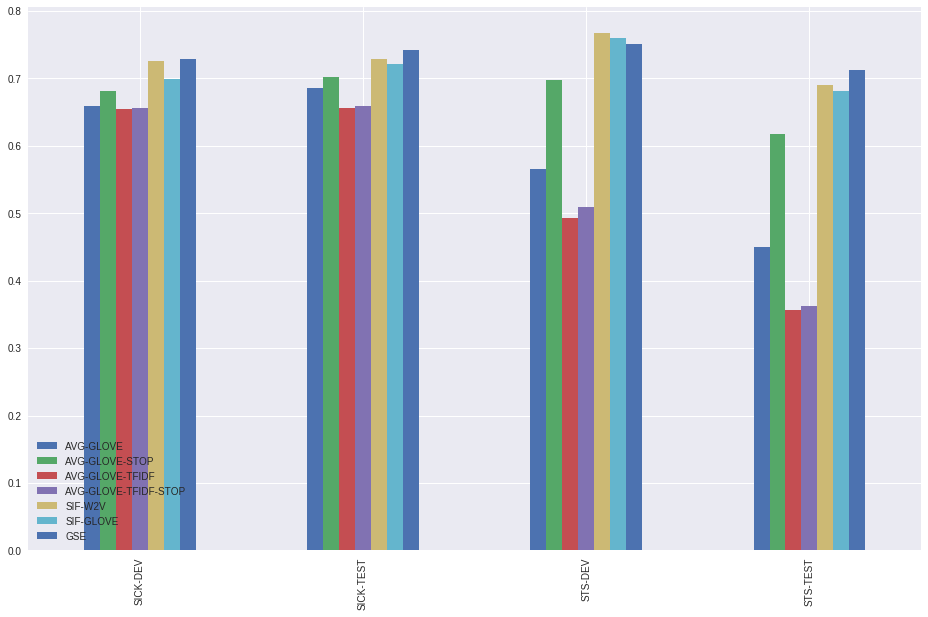

In [42]:
plt.rcParams['figure.figsize'] = (16,10)
pearson.plot(kind="bar").legend(loc="lower left")